**Import **

In [1]:
import shutil
import glob
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import os
import matplotlib.pyplot as plt
import json
import glob
from tqdm.notebook import tqdm
import seaborn as sns

In [2]:
train = pd.read_json("/Users/romainbrule/Documents/Cours/Master2/KAGGLE/stanford-covid-vaccine/train.json",lines=True)
train.set_index('index',inplace=True)
train

,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
index,,,,,,,,,,,,,,,,,,
0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...","[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[11.8007, 12.7566, 5.7733, 5.7733, 5.7733, 5.7...","[121286.7181, 121286.7182, 121286.7181, 121286...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...","[4.2139, 3.9637000000000002, 3.2467, 2.4716, 1...","[3.0942, 3.015, 2.1212, 2.0552, 0.881500000000...","[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,id_ff84602f7,GGAAAAUAGCAGAGGAAAUACUAGAGCAAUUGCAAAGGCCGAUCAU...,........((..((......))...)).........(((..........,EEEEEEEESSIISSHHHHHHSSIIISSXXXXXXXXXSSSHHHHHHH...,4.036,1,1

### On sépare les lignes du tableau

In [3]:
def expend_feature (df):
    """
    Return a dataframe with expension of sequence
    
    Args:
        df (Dataframe): same format as train
        i_row (int): number of row we want to expand
    
    Returns:
        sub_df: a dataframe with:
        number of rows = seq_scored
        columns name:[id, base, base_structure_type, base_predicted_loop_type, reactivity_error,
        deg_error_Mg_pH10,deg_error_pH10, deg_error_Mg_50C, deg_error_50C, reactivity, 
        deg_Mg_pH10, deg_pH10, deg_Mg_50C, deg_50C]
    """
    if (df.shape[0] != df.id.nunique()):
        print('repetition in RNA sequnence, clean dataframe first')
        return # dose the same as retunr None, which exit the function 
    
    else:
        col_names = ['id','base', 'base_structure_type', 'base_predicted_loop_type', 'reactivity_error',
            'deg_error_Mg_pH10', 'deg_error_pH10', 'deg_error_Mg_50C', 'deg_error_50C', 'reactivity', 
            'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']

        #dataframe creation using list of lists
        # loop for each unique sequence
        sub_data = []
        for row_i in df.index:
            #loop for the legth of sequnece score (trian length is different from test)
            serie_i = df.loc[row_i] #panda series object
            seq_length  = serie_i['seq_scored']
            for seq_i in range (seq_length):
                seq_data = [serie_i['id'], serie_i['sequence'][seq_i],
                            serie_i['structure'][seq_i], serie_i['predicted_loop_type'][seq_i],
                            serie_i['reactivity_error'][seq_i], serie_i['deg_error_Mg_pH10'][seq_i],
                            serie_i['deg_error_pH10'][seq_i], serie_i['deg_error_Mg_50C'][seq_i],
                            serie_i['deg_error_50C'][seq_i], serie_i['reactivity'][seq_i],
                            serie_i['deg_Mg_pH10'][seq_i], serie_i['deg_pH10'][seq_i],
                            serie_i['deg_Mg_50C'][seq_i], serie_i['deg_50C'][seq_i]]
                sub_data.append(seq_data)

        sub_df = pd.DataFrame(sub_data, columns =col_names,  dtype = float) 
        return sub_df

In [4]:
seq = expend_feature(train)

In [5]:
seq.head()

,id,base,base_structure_type,base_predicted_loop_type,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_001f94081,G,.,E,0.1359,0.2613,0.2631,0.1501,0.2167,0.3297,0.7556,2.3375,0.3581,0.6382
1,id_001f94081,G,.,E,0.2070,0.3842,0.2860,0.2750,0.3475,1.5693,2.9830,3.5060,2.9683,3.4773
2,id_001f94081,A,.,E,0.1633,0.1372,0.0964,0.0947,0.1880,1.1227,0.2526,0.3008,0.2589,0.9988
3,id_001f94081,A,.,E,0.1452,0.2531,0.1574,0.1866,0.2124,0.8686,1.3789,1.0108,1.4552,1.3228
4,id_001f94081,A,.,E,0.1314,0.1798,0.1000,0.1369,0.1703,0.7217,0.6376,0.2635,0.7244,0.7877


On se rend compte qu'il y a des données qui sont completement abérrantes. Il faudra que l'on décide lesquels enlevés. Pour le print du début on décide de plot les moyenne pour enlever les valeurs trop éloignées

### Dégradation en fonction du milieu 

In [6]:
from statistics import mean

<Figure size 432x288 with 0 Axes>

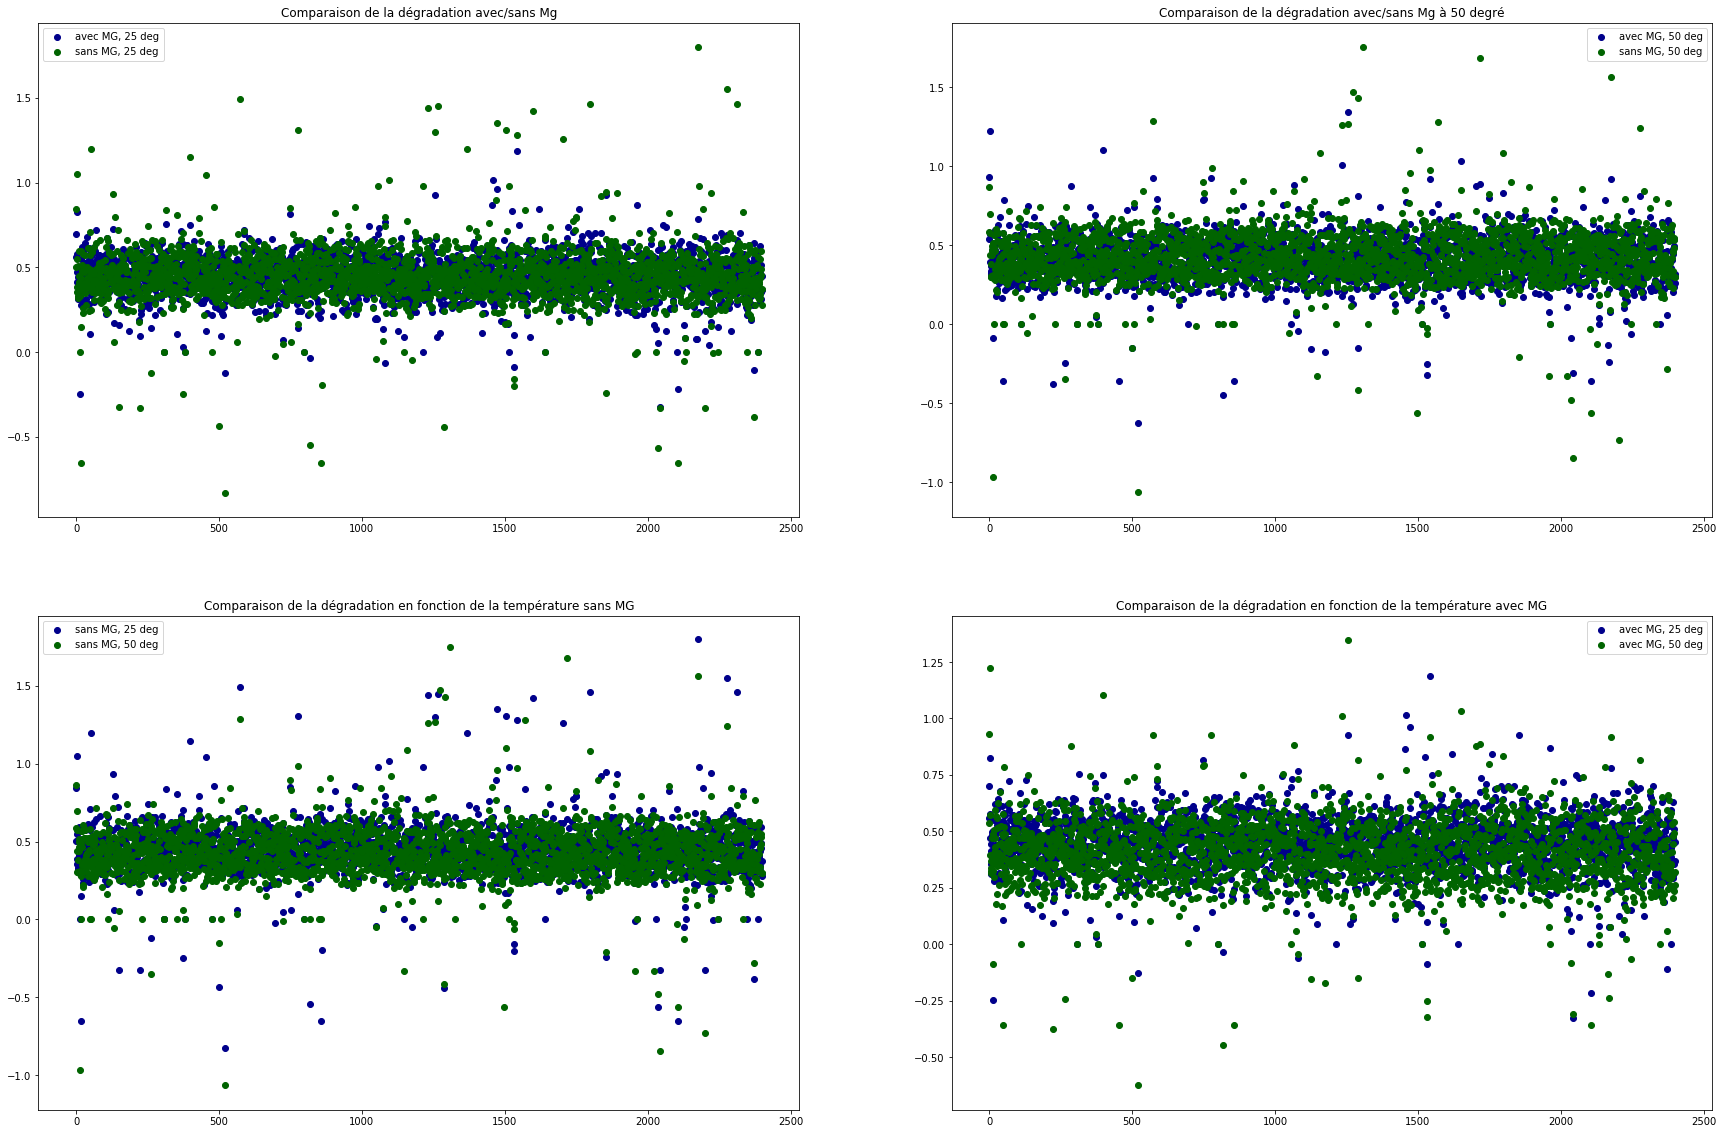

In [7]:
#Mean of degradation values
witMg=(train.deg_Mg_pH10).apply(lambda x: mean(x))
witoutMg=(train.deg_pH10).apply(lambda x: mean(x))

witMG_50=(train.deg_Mg_50C).apply(lambda x: mean(x))
witoutMg_50=(train.deg_50C).apply(lambda x: mean(x))

n=train.shape[0]
lon=np.arange(0,n)

# Plot 
plt.figure(1)
plt.figure(figsize = (30, 20)) 
plt.subplot(2, 2, 1)
plt.scatter(x=lon, y=witMg, color="DarkBlue", label="avec MG, 25 deg")
plt.scatter(x=lon, y=witoutMg, color="DarkGreen", label="sans MG, 25 deg")
plt.title("Comparaison de la dégradation avec/sans Mg")
plt.legend()
plt.subplot(2, 2, 2)
plt.scatter(x=lon, y=witMG_50, color="DarkBlue", label="avec MG, 50 deg")
plt.scatter(x=lon, y=witoutMg_50, color="DarkGreen", label="sans MG, 50 deg")
plt.title("Comparaison de la dégradation avec/sans Mg à 50 degré")
plt.legend()
plt.subplot(2, 2, 3)
plt.scatter(x=lon, y=witoutMg, color="DarkBlue", label="sans MG, 25 deg")
plt.scatter(x=lon, y=witoutMg_50, color="DarkGreen", label="sans MG, 50 deg")
plt.title("Comparaison de la dégradation en fonction de la température sans MG")
plt.legend()
plt.subplot(2, 2, 4)
plt.scatter(x=lon, y=witMg, color="DarkBlue", label="avec MG, 25 deg")
plt.scatter(x=lon, y=witMG_50, color="DarkGreen", label="avec MG, 50 deg")
plt.title("Comparaison de la dégradation en fonction de la température avec MG")
plt.legend()
plt.show()

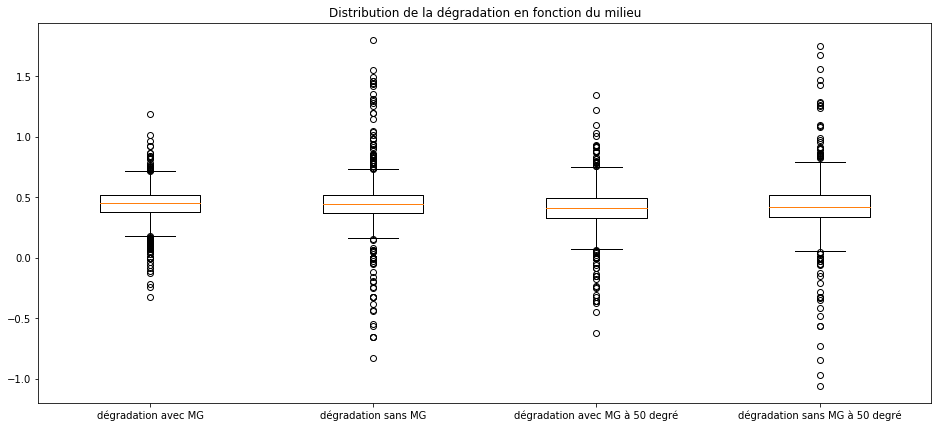

In [8]:
Comparaison=[]
Comparaison.append(witMg)
Comparaison.append(witoutMg)
Comparaison.append(witMG_50)
Comparaison.append(witoutMg_50)

plt.figure(figsize=(16,7))
plt.boxplot(Comparaison)
plt.gca().xaxis.set_ticklabels(['dégradation avec MG','dégradation sans MG', 'dégradation avec MG à 50 degré','dégradation sans MG à 50 degré'])
plt.title("Distribution de la dégradation en fonction du milieu")
plt.show()

On percoit ici que d'ajouter du magnésium permet de limiter les valeurs extrèmes de la dégradation.

### On s'interesse aux nucléotides : base

In [9]:
seq.groupby('base').describe()

reactivity_error                                                      \
                count         mean           std     min     25%      50%   
base                                                                        
A             59695.0  1022.776804  11327.343603  0.0019  0.0583  0.10080   
C             30908.0  5506.781985  26493.526101  0.0022  0.0321  0.05835   
G             43852.0  4730.593867  24715.614607  0.0033  0.0440  0.08310   
U             28745.0   828.757384  10018.840931  0.0029  0.0406  0.07520   

                           deg_error_Mg_pH10               ... deg_Mg_50C  \
           75%         max             count         mean  ...        75%   
base                                                       ...              
A     0.190700  146151.225           59695.0   963.896547  ...   0.673500   
C     0.121025  146151.225           30908.0  4184.863159  ...   0.384750   
G     0.177125  146151.225           43852.0  3666.905822  ...   0.527425   
U     0.168100  146151.225           28745.0  1149.024955  ...   0.523900   

               deg_50C                                                         \
          max    count      mean       std      min     25%     50%       75%   
base                                                                            
A     24.2525  59695.0  0.493038  1.041648 -38.3399  0.1920  0.4163  0.688700   
C     24.2525  30908.0  0.290865  1.265812 -38.3399  0.0437  0.1865  0.444725   
G     24.2525  43852.0  0.441230  1.170434 -38.3399  0.0795  0.2789  0.621400   
U     24.2549  28745.0  0.408224  1.027784 -38.3399  0.0596  0.2341  0.584300   

               
          max  
base           
A     38.3399  
C     38.3438  
G     38.3438  
U     38.3399  

[4 rows x 80 columns]

<Figure size 432x288 with 0 Axes>

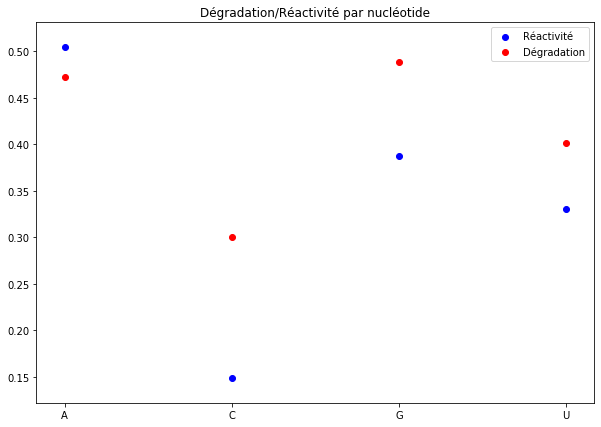

In [10]:
letters_nucleotide=['A','C','G','U']
res1=seq.groupby('base').mean().reactivity #mean of reactivity per base
res2=(seq.groupby('base').mean()).loc[:,['deg_Mg_pH10', 'deg_pH10','deg_Mg_50C','deg_50C']].mean(axis=1) 
#mean of degradation per base

#Plot
plt.figure(1)
plt.figure(figsize = (10, 7)) 
plt.scatter(letters_nucleotide, y=res1, color="blue", label="Réactivité")
plt.scatter(letters_nucleotide, y=res2, color="red", label="Dégradation")
plt.title("Dégradation/Réactivité par nucléotide")
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

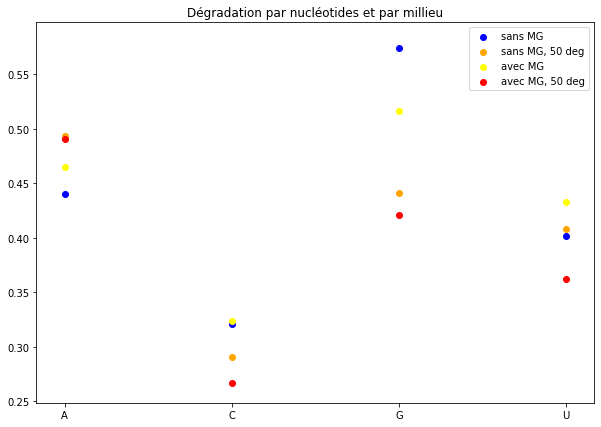

In [11]:
without_MG=(seq.groupby('base').mean()).loc[:,['deg_pH10']]
without_MG_50=(seq.groupby('base').mean()).loc[:,['deg_50C']]
with_MG=(seq.groupby('base').mean()).loc[:,['deg_Mg_pH10']]
with_MG_50=(seq.groupby('base').mean()).loc[:,['deg_Mg_50C']]

# Plot degradation per letter per field
plt.figure(1)
plt.figure(figsize = (10, 7)) 
plt.scatter(x=letters_nucleotide, y=without_MG, color="blue", label="sans MG")
plt.scatter(x=letters_nucleotide, y=without_MG_50, color="orange", label="sans MG, 50 deg")
plt.scatter(x=letters_nucleotide, y=with_MG, color="Yellow", label="avec MG")
plt.scatter(x=letters_nucleotide, y=with_MG_50, color="Red", label="avec MG, 50 deg")
plt.title("Dégradation par nucléotides et par millieu")
plt.legend()
plt.show()

### On s'interesse à leur disposition: predicted_loop_type

<Figure size 432x288 with 0 Axes>

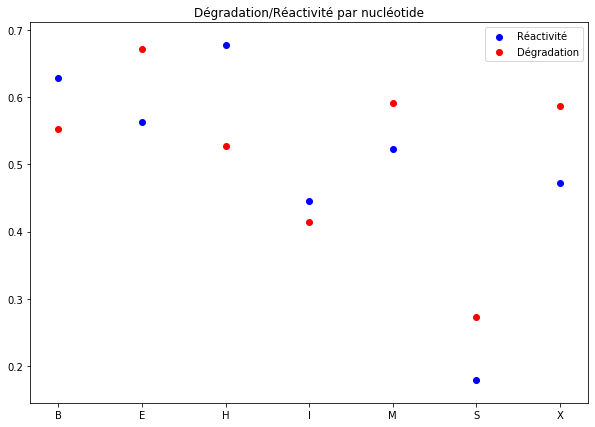

In [12]:
#Degradation/réactivity per shape
letters_loop_type=['B','E','H','I','M','S','X']

res1=seq.groupby('base_predicted_loop_type').mean().reactivity #mean of reactivity per base
res2=(seq.groupby('base_predicted_loop_type').mean()).loc[:,['deg_Mg_pH10', 'deg_pH10','deg_Mg_50C','deg_50C']].mean(axis=1) 
#mean of degradation per base

#Plot
plt.figure(1)
plt.figure(figsize = (10, 7)) 
plt.scatter(letters_loop_type, y=res1, color="blue", label="Réactivité")
plt.scatter(letters_loop_type, y=res2, color="red", label="Dégradation")
plt.title("Dégradation/Réactivité par nucléotide")
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

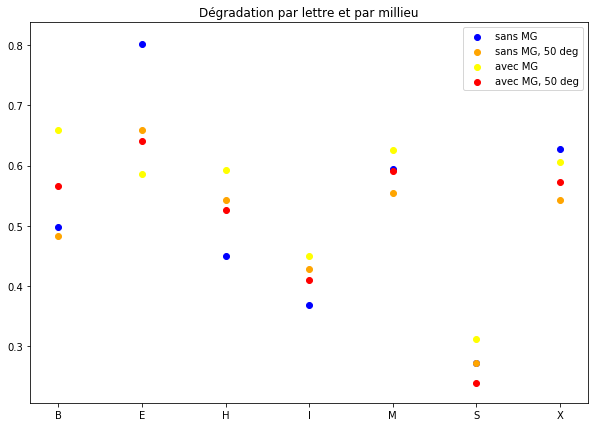

In [13]:
#Values per letter per millieu
without_MG=(seq.groupby('base_predicted_loop_type').mean()).loc[:,['deg_pH10']]
without_MG_50=(seq.groupby('base_predicted_loop_type').mean()).loc[:,['deg_50C']]
with_MG=(seq.groupby('base_predicted_loop_type').mean()).loc[:,['deg_Mg_pH10']]
with_MG_50=(seq.groupby('base_predicted_loop_type').mean()).loc[:,['deg_Mg_50C']]

# Plot degradation per letter per field
plt.figure(1)
plt.figure(figsize = (10, 7)) 
plt.scatter(x=letters_loop_type, y=without_MG, color="blue", label="sans MG")
plt.scatter(x=letters_loop_type, y=without_MG_50, color="orange", label="sans MG, 50 deg")
plt.scatter(x=letters_loop_type, y=with_MG, color="Yellow", label="avec MG")
plt.scatter(x=letters_loop_type, y=with_MG_50, color="Red", label="avec MG, 50 deg")
plt.title("Dégradation par lettre et par millieu")
plt.legend()
plt.show()

Les points bleu et orange de la lettre S sont pratiquement confondus: c'est pourquoi il n'est pas affiché

## On s'interesse à la dégradation en fonction du nombre de lettres "predicted_loop_type " collées

On estime que plus il y aura des lettres qui forment le meme groupe, moins il y aura de dégradation

In [14]:
# Coumpt the numerous of the group
gr=1
seq['count_gr']=gr
for i in range (1,seq.shape[0]):
    if ((seq.id.iloc[i]!=seq.id.iloc[i-1]) or (seq.base_predicted_loop_type.iloc[i]!=seq.base_predicted_loop_type.iloc[i-1])):
        gr=gr+1
    seq.count_gr[i]=gr

/Users/romainbrule/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [15]:
#Count the number of letters in the group 
def count(x,colonne):
    return (colonne==x).sum()


seq['N']=seq['count_gr'].apply(lambda x: count(x,seq['count_gr']))

<Figure size 432x288 with 0 Axes>

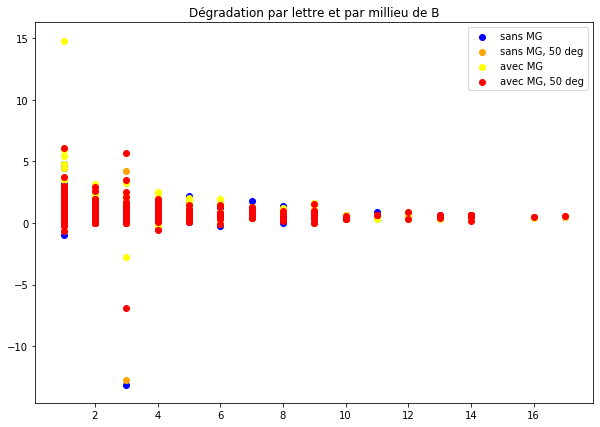

<Figure size 432x288 with 0 Axes>

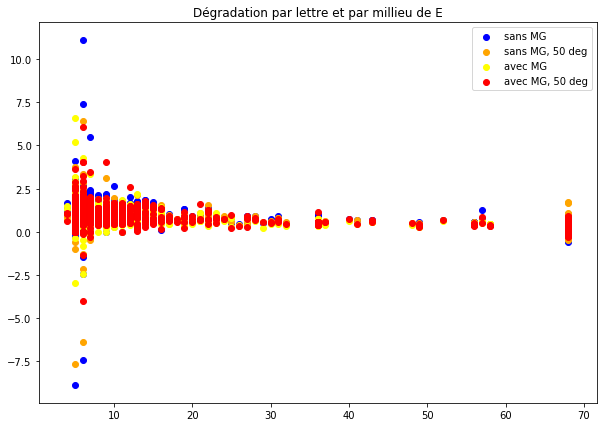

<Figure size 432x288 with 0 Axes>

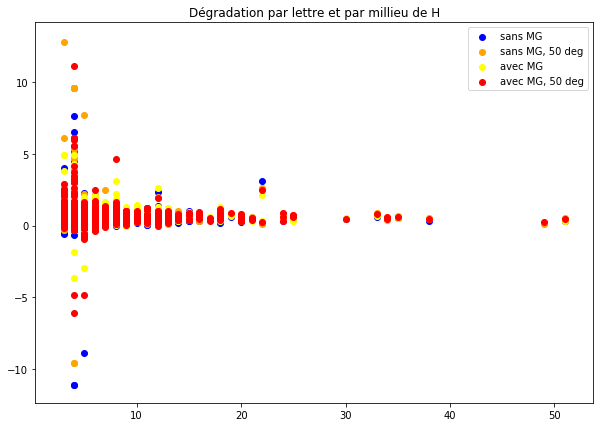

<Figure size 432x288 with 0 Axes>

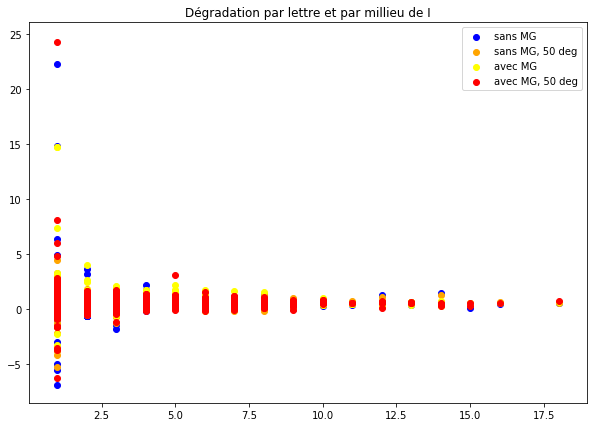

<Figure size 432x288 with 0 Axes>

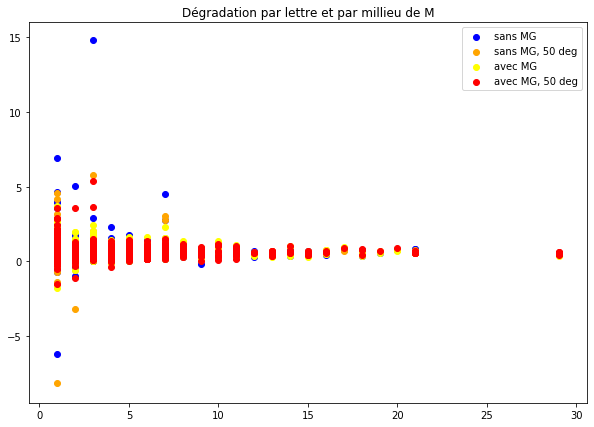

<Figure size 432x288 with 0 Axes>

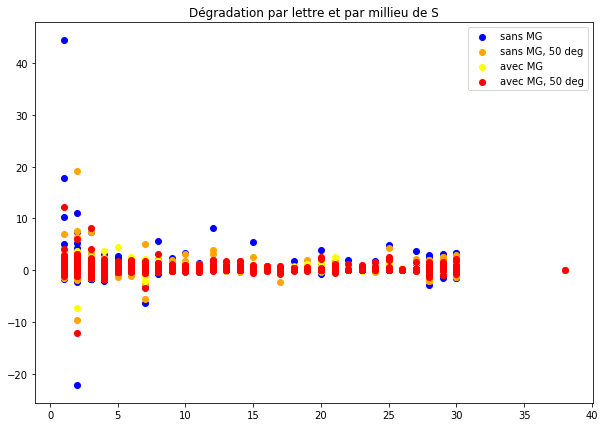

<Figure size 432x288 with 0 Axes>

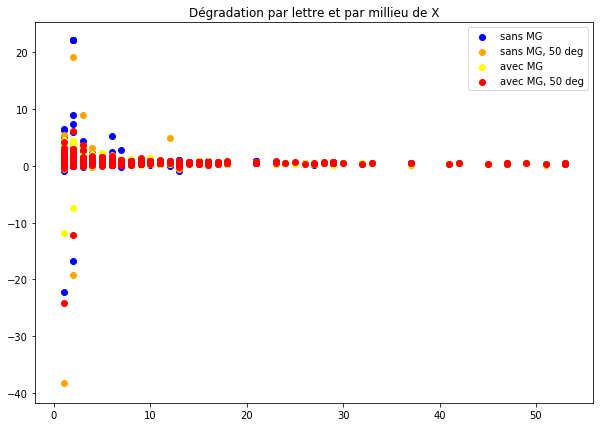

In [16]:
# Plot degradation per letter per field

for i in letters_loop_type:
    tab=(seq[seq.base_predicted_loop_type==i].groupby(["count_gr"]).mean())
    without_MG=tab.loc[:,['deg_pH10']]
    without_MG_50=tab.loc[:,['deg_50C']]
    with_MG=tab.loc[:,['deg_Mg_pH10']]
    with_MG_50=tab.loc[:,['deg_Mg_50C']]
    plt.figure(1)
    plt.figure(figsize = (10, 7)) 
    plt.scatter(x=tab.N, y=without_MG, color="blue", label="sans MG")
    plt.scatter(x=tab.N, y=without_MG_50, color="orange", label="sans MG, 50 deg")
    plt.scatter(x=tab.N, y=with_MG, color="Yellow", label="avec MG")
    plt.scatter(x=tab.N, y=with_MG_50, color="Red", label="avec MG, 50 deg")
    plt.title("Dégradation par lettre et par millieu de "+i)
    plt.legend()
    plt.show()

On voit bien que plus la "base_predicted_loop_type" est longue, plus la molécule est stable.

## On s'interesse à la dégradation en fonction du nombre de lettres "base" collées

In [17]:
# Coumpt the numerous of the group
gr=1
seq['count_gr_base']=gr
for i in range (1,seq.shape[0]):
    if ((seq.id.iloc[i]!=seq.id.iloc[i-1]) or (seq.base.iloc[i]!=seq.base.iloc[i-1])):
        gr=gr+1
    seq.count_gr_base[i]=gr

/Users/romainbrule/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [18]:
seq['N_base']=seq['count_gr_base'].apply(lambda x: count(x,seq['count_gr_base']))

<Figure size 432x288 with 0 Axes>

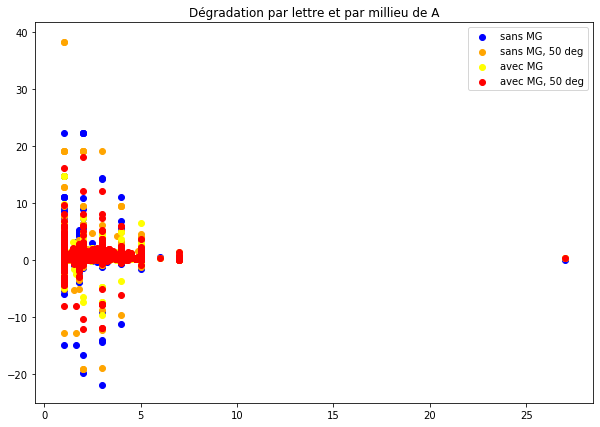

<Figure size 432x288 with 0 Axes>

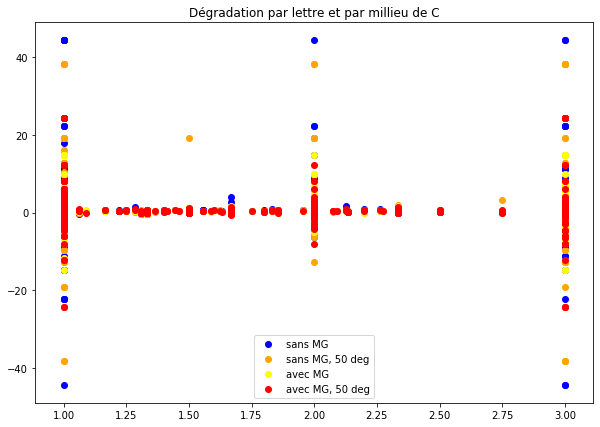

<Figure size 432x288 with 0 Axes>

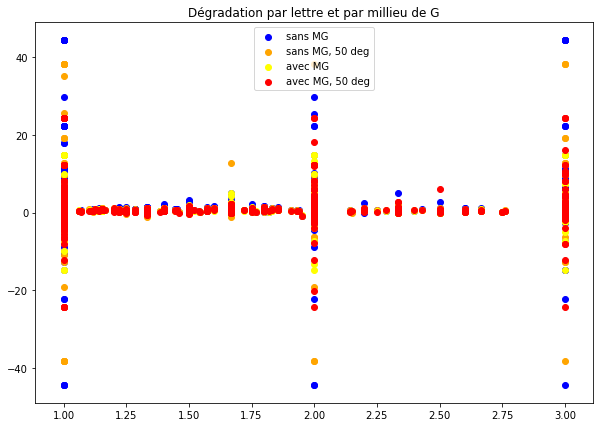

<Figure size 432x288 with 0 Axes>

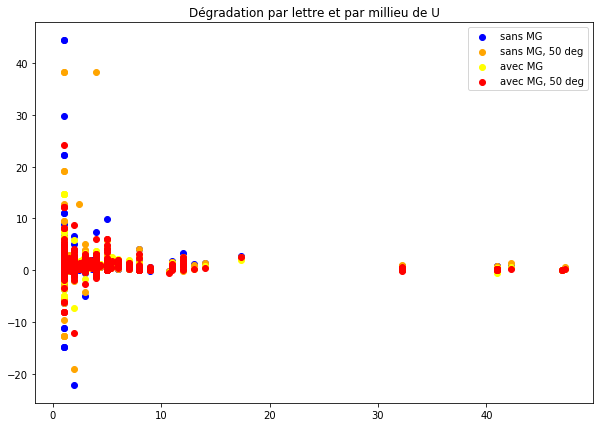

In [82]:
# Plot degradation per letter per field

for i in letters_nucleotide:
    tab=(seq[seq.base==i].groupby(["count_gr_base"]).mean())
    without_MG=tab.loc[:,['deg_pH10']]
    without_MG_50=tab.loc[:,['deg_50C']]
    with_MG=tab.loc[:,['deg_Mg_pH10']]
    with_MG_50=tab.loc[:,['deg_Mg_50C']]
    plt.figure(1)
    plt.figure(figsize = (10, 7)) 
    plt.scatter(x=tab.N_base, y=without_MG, color="blue", label="sans MG")
    plt.scatter(x=tab.N_base, y=without_MG_50, color="orange", label="sans MG, 50 deg")
    plt.scatter(x=tab.N_base, y=with_MG, color="Yellow", label="avec MG")
    plt.scatter(x=tab.N_base, y=with_MG_50, color="Red", label="avec MG, 50 deg")
    plt.title("Dégradation par lettre et par millieu de "+i)
    plt.legend()
    plt.show()

On peut voir que les résultats sont concluants ppour la lettre 'A' et 'U'

## Nouvelle features taille de la molécule

On part du principe que plus il y a de points, plus la longeur de la molécule est importante et moins elle est dense. Ainsi plus il y a des points, plus la réactivité et la dégradation devrait être important

In [78]:
#Count the number of '.' in molecules
Number_point=seq[seq.base_structure_type=='.'].groupby(["id"])['base_structure_type'].count()
seq['N_point']=Number_point[0]
idx=0
for i in range (1,seq.shape[0]):
    if (seq.id.iloc[i]!=seq.id.iloc[i-1]):
        idx+=1
        seq.loc[i,['N_point']]=Number_point[idx]

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

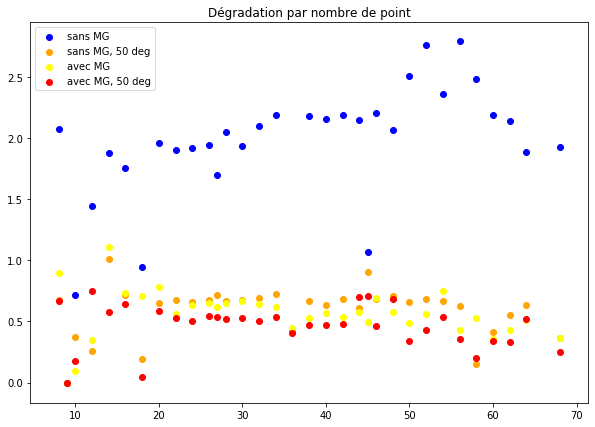

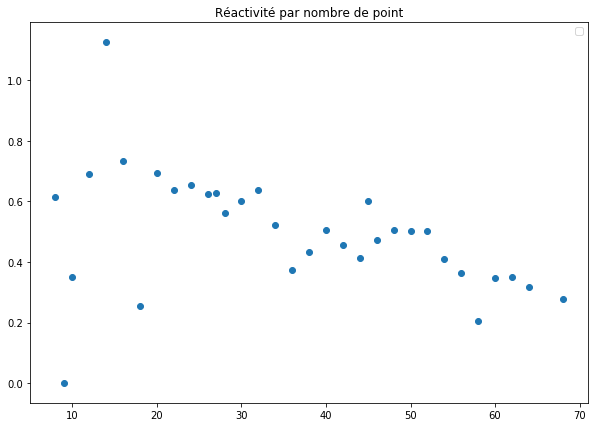

In [97]:
# Plot degradation per number of points
tab=(seq.groupby(["N_point"]).mean())
vect= tab.index.tolist()

without_MG=tab.loc[:,['deg_pH10']]
without_MG_50=tab.loc[:,['deg_50C']]
with_MG=tab.loc[:,['deg_Mg_pH10']]
with_MG_50=tab.loc[:,['deg_Mg_50C']]
rea=tab.loc[:,['reactivity']]

plt.figure(1)
plt.figure(figsize = (10, 7)) 
plt.scatter(x=vect, y=without_MG, color="blue", label="sans MG")
plt.scatter(x=vect, y=without_MG_50, color="orange", label="sans MG, 50 deg")
plt.scatter(x=vect, y=with_MG, color="Yellow", label="avec MG")
plt.scatter(x=vect, y=with_MG_50, color="Red", label="avec MG, 50 deg")
plt.title("Dégradation par nombre de point")
plt.legend()

plt.figure(2)
plt.figure(figsize = (10, 7)) 
plt.scatter(x=vect, y=rea)
plt.title("Réactivité par nombre de point")
plt.legend()

plt.show()

La dégradation ne semble pas indiquer grand chose mais on peut voir que la réactivité semble changer en fonction du nombre de point dans la molécule.

### On veut étudier les variables base/structure/loop_type_replace

    Au début voici comment nous avons choisie de coder ces variables. 

In [17]:
#base_replace = {'G':0, 'A':1, 'C':2, 'U':3}
#structure_replace ={'.':0, '(':1, ')':2}
#loop_type_replace = {'E':0, 'S':1, 'H':2, 'B':3, 'X':4, 'I':5, 'M':6}

#replace_types = [base_replace, structure_replace, loop_type_replace]



    Or cela n'est pas acceptable car nous avons instaurer un rapport de superiorité avec des valeurs qui n'ont pas de relation d'ordre. On décide donc de passer à l'encodage one-hot

In [18]:
# vary the proportion of S/N data in the train test, use validation set to tune the 
def fianle_transform (dataframe):
    # filter with SN_filter criteria 
    data_filter = dataframe[dataframe["SN_filter"] == 1]
    
    #use expend to change feature 
    data_filter_seq = expend_feature(data_filter)
    
    #make feature onehot encoding
    one_hot_base = pd.get_dummies(data_filter_seq['base'],drop_first=True) #drop "A"
    one_hot_loop = pd.get_dummies(data_filter_seq['base_predicted_loop_type'],drop_first=True) # drop "B"
    one_hot_struct = pd.get_dummies(data_filter_seq['base_structure_type'],drop_first=True)# drop "("
    
    #final dataset
    data_filter_seq = data_filter_seq.drop(["base", "base_predicted_loop_type","base_structure_type"], axis = 1)
    df = pd.concat([data_filter_seq,one_hot_base, one_hot_loop ,one_hot_struct], axis = 1)
    return df

In [19]:
seq_filter = fianle_transform(train)

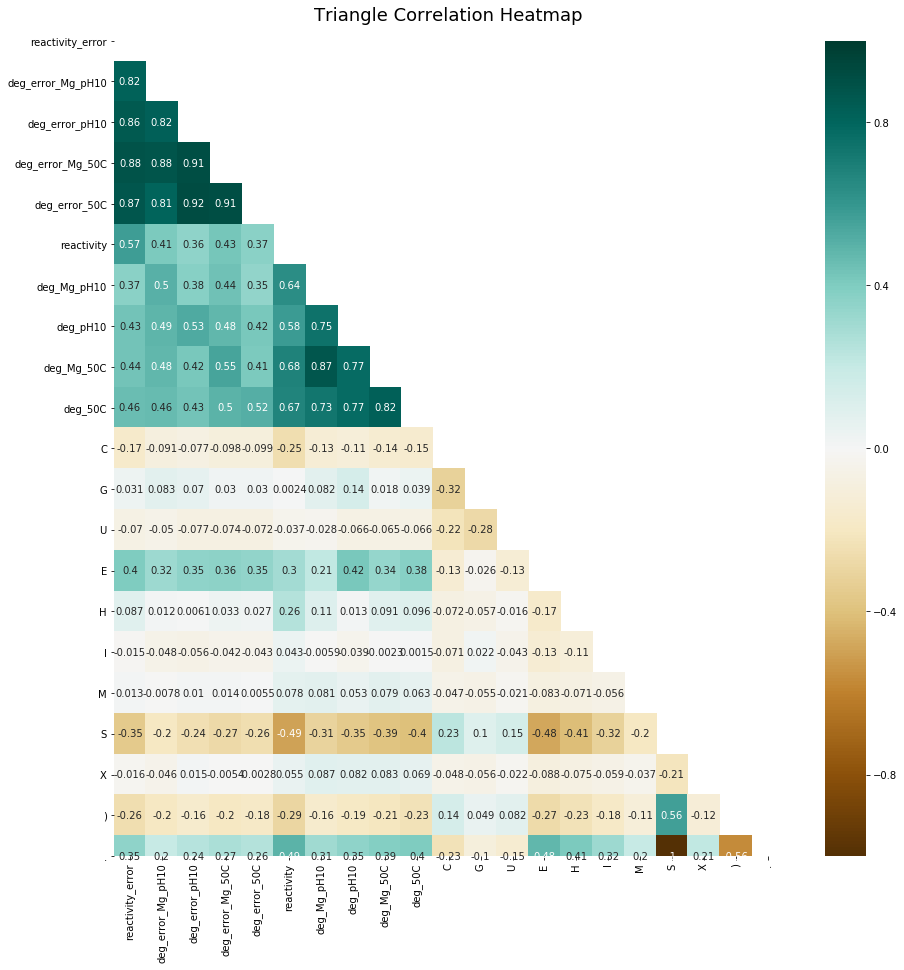

In [20]:
fig, ax = plt.subplots(figsize=(15,15)) 
mask = np.triu(np.ones_like(seq_filter.corr(method= 'pearson'), dtype=np.bool))
heatmap = sns.heatmap(seq_filter.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=20);

In [39]:
seq_filter.to_csv('seq_filter.csv')